<a href="https://colab.research.google.com/github/AnamarijaKozina/Duboko-ucenje-FER/blob/main/pt_deep_with_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import random

In [39]:
class Random2DGaussian:
  """Random bivariate normal distribution sampler

  Hardwired parameters:
      d0min,d0max: horizontal range for the mean
      d1min,d1max: vertical range for the mean
      scalecov: controls the covariance range 

  Methods:
      __init__: creates a new distribution

      get_sample(n): samples n datapoints

  """

  d0min=0 
  d0max=10
  d1min=0 
  d1max=10
  scalecov=5
  
  def __init__(self):
    dw0,dw1 = self.d0max-self.d0min, self.d1max-self.d1min
    mean = (self.d0min,self.d1min)
    mean += np.random.random_sample(2)*(dw0, dw1)
    eigvals = np.random.random_sample(2)
    eigvals *= (dw0/self.scalecov, dw1/self.scalecov)
    eigvals **= 2
    theta = np.random.random_sample()*np.pi*2
    R = [[np.cos(theta), -np.sin(theta)], 
         [np.sin(theta), np.cos(theta)]]
    Sigma = np.dot(np.dot(np.transpose(R), np.diag(eigvals)), R)
    self.get_sample = lambda n: np.random.multivariate_normal(mean,Sigma,n)

  
def graph_surface(function, model, rect, offset=0.5, width=256, height=256):
  """Creates a surface plot (visualize with plt.show)

  Arguments:
    function: surface to be plotted
    rect:     function domain provided as:
              ([x_min,y_min], [x_max,y_max])
    offset:   the level plotted as a contour plot

  Returns:
    None
  """

  lsw = np.linspace(rect[0][1], rect[1][1], width) 
  lsh = np.linspace(rect[0][0], rect[1][0], height)
  xx0,xx1 = np.meshgrid(lsh, lsw)
  grid = np.stack((xx0.flatten(),xx1.flatten()), axis=1)
  

  #get the values and reshape them
  values=function(model,grid).reshape((width,height))
  
  # fix the range and offset
  delta = offset if offset else 0
  maxval=max(np.max(values)-delta, - (np.min(values)-delta))
  
  # draw the surface and the offset
  plt.pcolormesh(xx0, xx1, values, 
     vmin=delta-maxval, vmax=delta+maxval)
    
  if offset != None:
    plt.contour(xx0, xx1, values, colors='red', levels=[offset])

def graph_data(X,Y_, Y, special=[]):
  """Creates a scatter plot (visualize with plt.show)

  Arguments:
      X:       datapoints
      Y_:      groundtruth classification indices
      Y:       predicted class indices
      special: use this to emphasize some points

  Returns:
      None
  """
  # colors of the datapoint markers
  palette=([0.5,0.5,0.5], [1,1,1], [0.2,0.2,0.2])
  colors = np.tile([0.0,0.0,0.0], (Y_.shape[0],1))
  for i in range(len(palette)):
    colors[Y_==i] = palette[i]

  # sizes of the datapoint markers
  sizes = np.repeat(20, len(Y_))
  sizes[special] = 40
  
  # draw the correctly classified datapoints
  good = (Y_==Y)
  plt.scatter(X[good,0],X[good,1], c=colors[good], 
              s=sizes[good], marker='o', edgecolors='black')

  # draw the incorrectly classified datapoints
  bad = (Y_!=Y)
  plt.scatter(X[bad,0],X[bad,1], c=colors[bad], 
              s=sizes[bad], marker='s', edgecolors='black')

def class_to_onehot(Y):
  Yoh=np.zeros((len(Y),max(Y)+1))
  Yoh[range(len(Y)),Y] = 1
  return Yoh

def eval_perf_multi(Y, Y_):
  pr = []
  n = max(Y_)+1
  M = np.bincount(n * Y_ + Y, minlength=n*n).reshape(n, n)
  for i in range(n):
    tp_i = M[i,i]
    fn_i = np.sum(M[i,:]) - tp_i
    fp_i = np.sum(M[:,i]) - tp_i
    tn_i = np.sum(M) - fp_i - fn_i - tp_i
    recall_i = tp_i / (tp_i + fn_i)
    precision_i = tp_i / (tp_i + fp_i)
    pr.append( (recall_i, precision_i) )
  
  accuracy = np.trace(M)/np.sum(M)
  
  return accuracy, pr, M

def eval_AP(ranked_labels):
  """Recovers AP from ranked labels"""
  
  n = len(ranked_labels)
  pos = sum(ranked_labels)
  neg = n - pos
  
  tp = pos
  tn = 0.
  fn = 0.
  fp = neg
  
  sumprec=0
  #IPython.embed()
  for x in ranked_labels:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)    

    if x:
      sumprec += precision
      
    #print (x, tp,tn,fp,fn, precision, recall, sumprec)
    #IPython.embed()

    tp -= x
    fn += x
    fp -= not x
    tn += not x

  return sumprec/pos

def sample_gmm_2d(ncomponents, nclasses, nsamples):
  # create the distributions and groundtruth labels
  Gs=[]
  Ys=[]
  for i in range(ncomponents):
    Gs.append(Random2DGaussian())
    Ys.append(np.random.randint(nclasses))

  # sample the dataset
  X = np.vstack([G.get_sample(nsamples) for G in Gs])
  Y_= np.hstack([[Y]*nsamples for Y in Ys])
  
  return X,Y_

In [40]:
class PTDeep(nn.Module):
  def __init__(self, layer_sizes, activation = torch.relu): 
    super().__init__()

    self.layers = len(layer_sizes)-1

    self.weights = nn.ParameterList([nn.Parameter(torch.randn(layer_sizes[i], layer_sizes[i+1]), requires_grad=True) for i in range(self.layers)])
    self.biases = nn.ParameterList([nn.Parameter(torch.randn(layer_sizes[i+1]), requires_grad=True) for i in range(self.layers)])

    self.activation = activation

  def forward(self, X): # X: N x dim
    for i in range(self.layers-1):
      X = torch.mm(X, self.weights[i]) + self.biases[i]
      X = X - X.mean(axis=0)
      X = X / X.std(axis=0)
      X = self.activation(X)
    X = torch.mm(X, self.weights[self.layers-1]) + self.biases[self.layers-1]
    return torch.softmax(X, axis=1)


  def get_loss(self, X, Yoh_, param_lambda): 
    Y_pred = self.forward(X)
    #reg = sum([torch.norm(w) for w in self.weights])
    loss = - torch.mean(torch.sum(torch.log(Y_pred)*Yoh_, axis=1)) #+ reg * param_lambda
    return loss

  def count_params(self):
    for name, p in self.named_parameters():
      print(f'Parametar {name} ima oblik {p.shape}')


def train(model, X, Yoh_, param_niter, param_delta):
 
  optimizer = torch.optim.SGD(model.parameters(), lr = param_delta)
  
  for iter in range(param_niter):
    optimizer.zero_grad()
    loss = model.get_loss(X, Yoh_, 0.5)
    if iter%500==0:
      print(f"Korak {iter+1}, gubitak = {loss}")
    loss.backward()
    optimizer.step()
    

def eval(model, X):
  """Arguments:
     - model: type: PTLogreg
     - X: actual datapoints [NxD], type: np.array
     Returns: predicted class probabilites [NxC], type: np.array
  """
  # ulaz je potrebno pretvoriti u torch.Tensor
  # izlaze je potrebno pretvoriti u numpy.array
  # koristite torch.Tensor.detach() i torch.Tensor.numpy()
  X_tensor = torch.tensor(X, dtype=torch.float32)
  outputs = model.forward(X_tensor).detach().numpy() # N x C
  return outputs

def eval_class(model, X):
  out = eval(model, X)
  return np.argmax(out, axis=1)

def eval_for_binary(model, X):
  return eval(model, X)[:,0]

Korak 1, gubitak = 1.4501593112945557
Korak 501, gubitak = 0.11962592601776123
Korak 1001, gubitak = 0.08392582833766937
Korak 1501, gubitak = 0.07048585265874863
Korak 2001, gubitak = 0.062196701765060425
Korak 2501, gubitak = 0.05630125850439072
Korak 3001, gubitak = 0.05218315124511719
Korak 3501, gubitak = 0.04944960027933121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Average precision: 0.9989326478498123


Tocnost: 0.98125
Odaziv i preciznost, redom za klase: [(0.9875, 0.9753086419753086), (0.975, 0.9873417721518988)]
Matrica konfuzije:
[[79  1]
 [ 2 78]]

Parametar weights.0 ima oblik torch.Size([2, 10])
Parametar weights.1 ima oblik torch.Size([10, 50])
Parametar weights.2 ima oblik torch.Size([50, 50])
Parametar weights.3 ima oblik torch.Size([50, 10])
Parametar weights.4 ima oblik torch.Size([10, 2])
Parametar biases.0 ima oblik torch.Size([10])
Parametar biases.1 ima oblik torch.Size([50])
Parametar biases.2 ima oblik torch.Size([50])
Parametar biases.3 ima oblik torch.Size([10])
Parametar biases.4 ima oblik torch.Size([2])


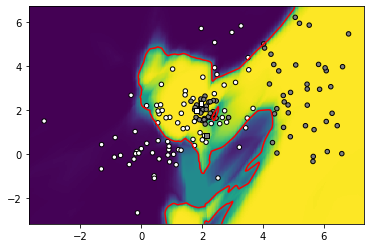

In [41]:
if __name__ == "__main__":
  # inicijaliziraj generatore slučajnih brojeva
  np.random.seed(100)

  # instanciraj podatke X i labele Yoh_
  X_orig, Y_orig_ = sample_gmm_2d(4, 2, 40)
  X = torch.tensor(X_orig, dtype=torch.float32)
  Yoh_ = class_to_onehot(Y_orig_)
  Yoh_ = torch.tensor(Yoh_, dtype=torch.float32)

  ptdeep = PTDeep([2,10,50,50,10,2], activation = torch.relu)

  train(ptdeep, X, Yoh_, 4000, 0.05)

  probs = eval(ptdeep, X)

  Y_pred = torch.argmax(torch.tensor(probs), axis=1) # matrica predvidenih razreda, 0/1
  Y_ = torch.tensor(Y_orig_)

  indices = np.argsort(probs[:,1])
  Y_ranked = Y_.numpy()[indices]
  print(f"\nAverage precision: {eval_AP(Y_ranked)}\n")

  accuracy, pr, M = eval_perf_multi(Y_pred, Y_)
  print(f"\nTocnost: {accuracy}\nOdaziv i preciznost, redom za klase: {pr}\nMatrica konfuzije:\n{M}\n")
  
  ptdeep.count_params()

  # graph the decision surface
  rect = (np.min(X_orig, axis=0) - 0.5, np.max(X_orig, axis=0) + 0.5)

  graph_surface(eval_for_binary, ptdeep, rect, offset=0.5)  # if C>2, function should be eval_class, otherwise can be eval_for_binary to get gradients

  Y_pred = eval_class(ptdeep, X_orig)

  # graph the data points
  graph_data(X_orig, Y_orig_, Y_pred, special=[])

  plt.show()